In [1]:
#Investment Strategies

#1) Randomly choose a predetermined # of loans

#2) Predict the returns using a model and invest in the highest predicted ones

#3) Predict the returns for defaulted and paid off separately, and combine with the 
#   predictd default rate to invest in the ones with highest expected returns

#Run optimizations given a budget constraint and a risk tolerance?

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from pprint import pprint

sns.set(style="whitegrid")

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from sklearn import tree

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

In [48]:
#Read in a bunch of csv files and stack them together

path =r'C:\\Users\\armcl\\Python\\Lending Club\\Data' 
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f,skiprows=[0],header=0,low_memory=False) for f in all_files)
lc_all   = pd.concat(df_from_each_file, ignore_index=True)

In [49]:
#Remove all NAs data
lc_all.dropna(subset=['loan_status'], inplace=True)

#int rate to numeric
lc_all['int_rate'] = pd.to_numeric(lc_all['int_rate'].str.replace("%", "").str.replace(" ", ""))

#Extract the initiation year feature
lc_all['issue_d'] = pd.to_datetime(lc_all['issue_d'])
lc_all['last_pymnt_d'] = pd.to_datetime(lc_all['last_pymnt_d'])
lc_all['issue_y'] = lc_all['issue_d'].dt.year

#Defaulted loans are tiny and let's relabel them to charge off, they're 121-150 days past due loans
lc_all['loan_status'].replace({'Default':'Charged Off'}, inplace=True)

In [50]:
#Capture the prepaid loans which is defined as abs(actual maturity - term) > 2

lc_all = lc_all.loc[lc_all['loan_status'].isin(['Fully Paid','Charged Off']),:]

lc_all['term_num'] = lc_all['term'].replace({' 36 months':36,' 60 months':60})

#Annualized returns using term months assuming no reinvestments
#lc_final['return_reinvest'] = (pow((lc_final['total_pymnt']/lc_final['funded_amnt']),(12/lc_final['actual_term']))-1)*100
lc_all['return'] = (pow((lc_all['total_pymnt']/lc_all['funded_amnt']),(12/lc_all['term_num']))-1)*100

In [6]:
lc_all['return'].quantile([0,.01, .1, .25, 1/3, .5, 2/3, .75, .9, .99,1])

0.000000   -100.000000
0.010000    -43.289480
0.100000    -15.481673
0.250000      1.166970
0.333333      2.124575
0.500000      3.478158
0.666667      4.712473
0.750000      5.534646
0.900000      7.181539
0.990000     10.239338
1.000000     29.471225
Name: return, dtype: float64

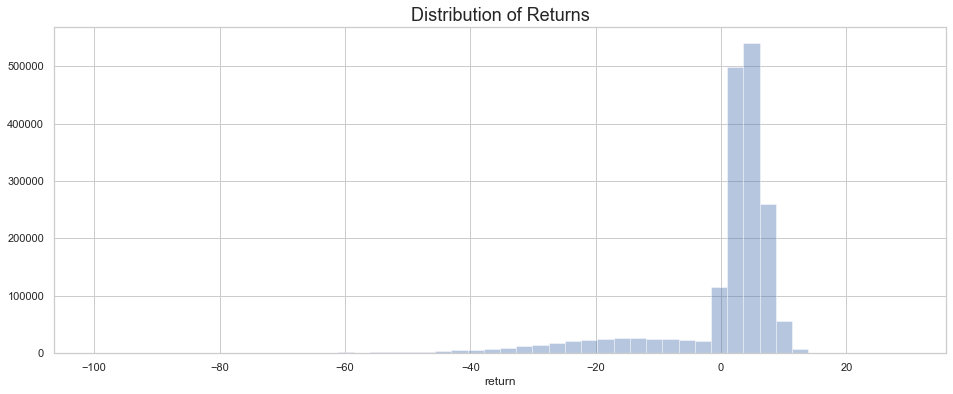

In [7]:
#Plot the distribution of returns
#Long tails on the left

plt.figure(figsize=(16, 6))
ax = sns.distplot(lc_all['return'],kde=False)
ax.set_title("Distribution of Returns", fontsize=18)
plt.show()

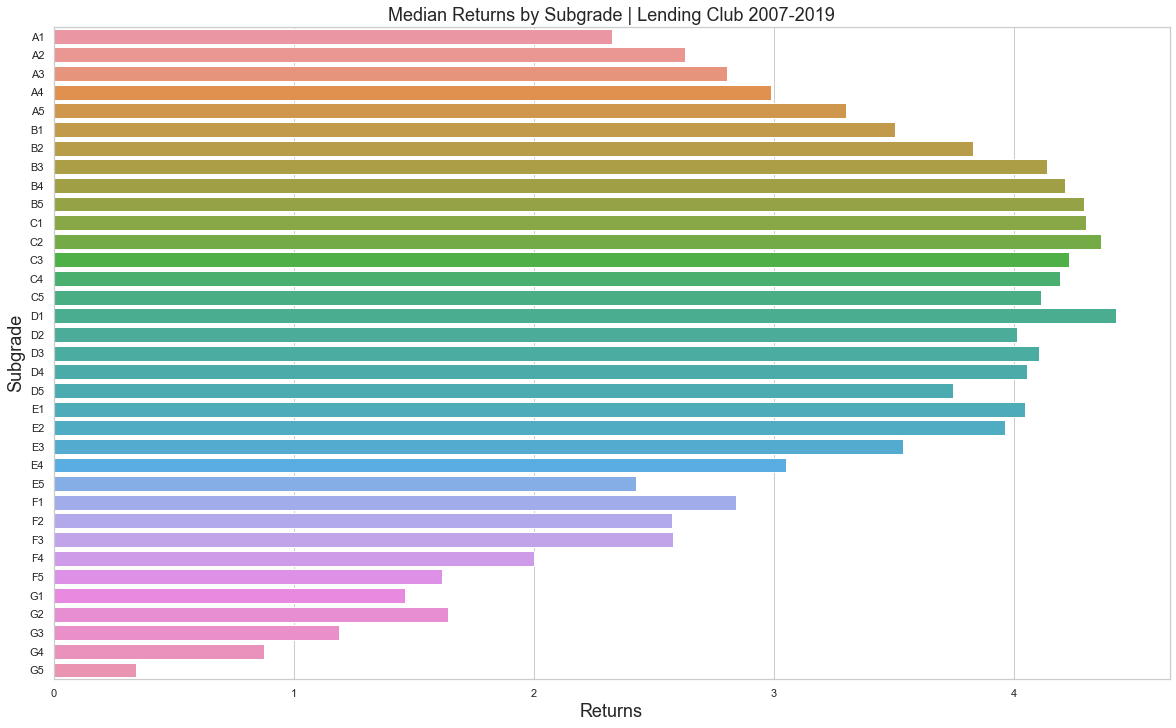

In [8]:
#Median returns by sub group

loan_return_by_grade = lc_all.groupby('sub_grade').median()

#Default Rate by subgrade
plt.figure(figsize=(20, 12))
sns.barplot(x=loan_return_by_grade['return'], y=loan_return_by_grade.index)

# Add labels to your graph
plt.xlabel('Returns', fontsize=18)
plt.ylabel('Subgrade', fontsize=18)
plt.title("Median Returns by Subgrade | Lending Club 2007-2019", fontsize=18)
plt.show()

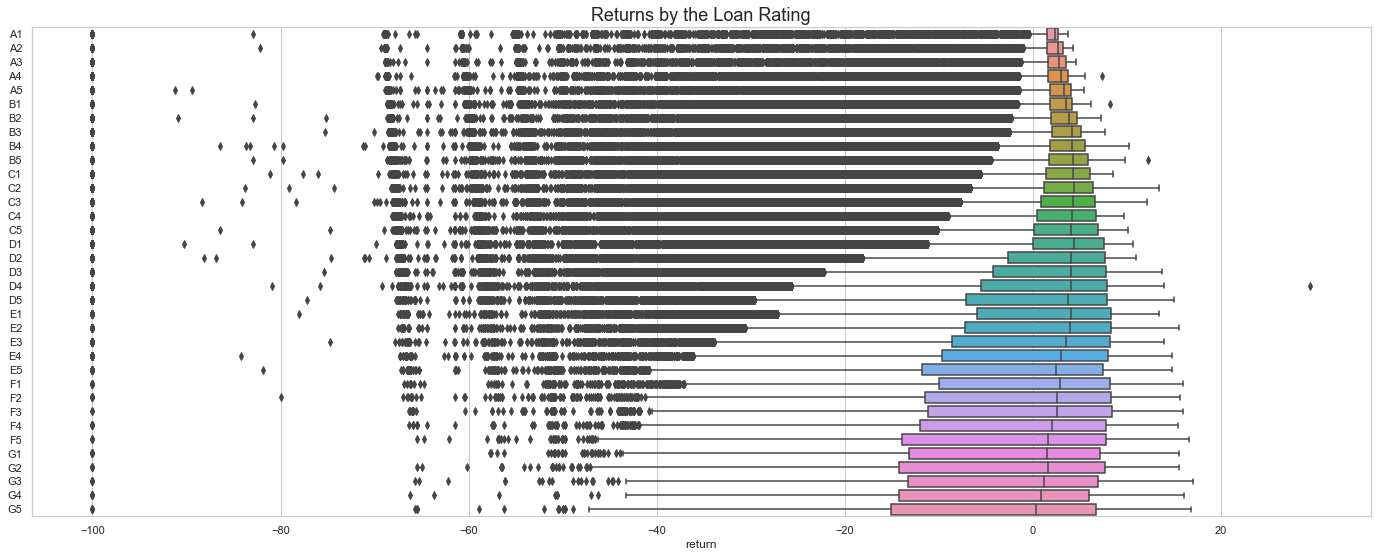

In [9]:
#Return by sub group
#Look the volatility increases as the grade gets lower

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="return", y='sub_grade', orient="h", data=lc_all.sort_values('sub_grade'))
ax.set_title("Returns by the Loan Rating", fontsize=18)
ax.set_ylabel('')

plt.show()

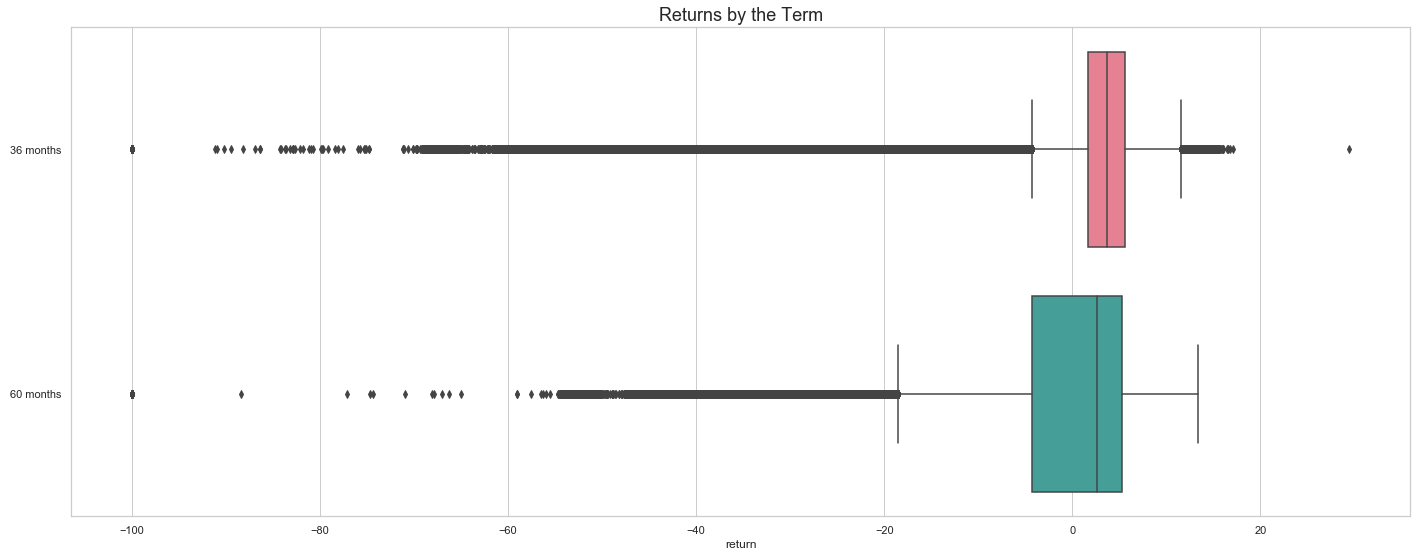

In [10]:
#Returns by term

plt.figure(figsize=(24, 9))
ax = sns.boxplot(x="return", y='term', orient="h", palette = 'husl', data=lc_all.sort_values('term'))
ax.set_title("Returns by the Term", fontsize=18)
ax.set_ylabel('')

plt.show()

In [11]:
#Avoid data leakage (remove features that were unknown at the time of the loan initiaion)
leakage_features = ['collection_recovery_fee','last_credit_pull_d','last_fico_range_high',
                    'last_fico_range_low','last_pymnt_amnt','last_pymnt_d','next_pymnt_d',
                    'num_tl_120dpd_2m','num_tl_30dpd','out_prncp','out_prncp_inv',
                    'recoveries','total_pymnt','total_pymnt_inv','total_rec_int',
                    'total_rec_late_fee','total_rec_prncp','debt_settlement_flag',
                    'debt_settlement_flag_date','settlement_status','settlement_date',
                    'settlement_amount','settlement_percentage','settlement_term',
                    'loan_status']

#Remove features that don't have much added information
#For example sub_grade is finer than grade
features_to_remove = leakage_features + ['emp_title','loan_amnt','funded_amnt_inv','grade',
                                         'id','member_id','title','url','zip_code',
                                         'pymnt_plan','policy_code','term_num']

lc_all = lc_all.drop(columns=features_to_remove)


In [12]:
#If join application, replace with the joint info

lc_all['revol_util'] = pd.to_numeric(lc_all['revol_util'].str.replace("%", ""))

lc_all.loc[lc_all['application_type']=='Joint App','annual_inc'] = lc_all.loc[lc_all['application_type']=='Joint App','annual_inc_joint']
lc_all.loc[lc_all['application_type']=='Joint App','dti'] = lc_all.loc[lc_all['application_type']=='Joint App','dti_joint']
lc_all.loc[lc_all['application_type']=='Joint App','verification_status'] = lc_all.loc[lc_all['application_type']=='Joint App','verification_status_joint']

lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['revol_bal_joint'].isnull()),'revol_bal'] = lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['revol_bal_joint'].isnull()),'revol_bal_joint']
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_low'].isnull()),'fico_range_low'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_low'].isnull()),'fico_range_low'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_low'].isnull()),'sec_app_fico_range_low'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_high'].isnull()),'fico_range_high'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_high'].isnull()),'fico_range_high'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_fico_range_high'].isnull()),'sec_app_fico_range_high'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_inq_last_6mths'].isnull()),'inq_last_6mths'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_inq_last_6mths'].isnull()),'inq_last_6mths'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_inq_last_6mths'].isnull()),'sec_app_inq_last_6mths'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mort_acc'].isnull()),'mort_acc'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mort_acc'].isnull()),'mort_acc'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mort_acc'].isnull()),'sec_app_mort_acc'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_acc'].isnull()),'open_acc'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_acc'].isnull()),'open_acc'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_acc'].isnull()),'sec_app_open_acc'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_revol_util'].isnull()),'revol_util'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_revol_util'].isnull()),'revol_util'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_revol_util'].isnull()),'sec_app_revol_util'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_act_il'].isnull()),'open_act_il'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_act_il'].isnull()),'open_act_il'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_open_act_il'].isnull()),'sec_app_open_act_il'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_num_rev_accts'].isnull()),'num_rev_accts'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_num_rev_accts'].isnull()),'num_rev_accts'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_num_rev_accts'].isnull()),'sec_app_num_rev_accts'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_chargeoff_within_12_mths'].isnull()),'chargeoff_within_12_mths'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_chargeoff_within_12_mths'].isnull()),'chargeoff_within_12_mths'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_chargeoff_within_12_mths'].isnull()),'sec_app_chargeoff_within_12_mths'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_collections_12_mths_ex_med'].isnull()),'collections_12_mths_ex_med'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_collections_12_mths_ex_med'].isnull()),'collections_12_mths_ex_med'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_collections_12_mths_ex_med'].isnull()),'sec_app_collections_12_mths_ex_med'])/2
lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mths_since_last_major_derog'].isnull()),'mths_since_last_major_derog'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mths_since_last_major_derog'].isnull()),'mths_since_last_major_derog'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_mths_since_last_major_derog'].isnull()),'sec_app_mths_since_last_major_derog'])/2

In [13]:
#Reduce the number of categories for home ownership
lc_all = lc_all.replace({'home_ownership' : {'ANY':'OTHER','NONE':'OTHER'}})

#Create dummy variables

lc_all = pd.concat([lc_all, lc_all['term'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, lc_all['sub_grade'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, pd.get_dummies(lc_all['home_ownership'],prefix="Home")], axis=1)
lc_all = pd.concat([lc_all, lc_all['verification_status'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, pd.get_dummies(lc_all['purpose'],prefix="purpose")], axis=1)
lc_all = pd.concat([lc_all, lc_all['addr_state'].str.get_dummies(sep=',')], axis=1)
lc_all = pd.concat([lc_all, pd.get_dummies(lc_all['initial_list_status'],prefix="list_status")], axis=1)
lc_all = pd.concat([lc_all, lc_all['application_type'].str.get_dummies(sep=',')], axis=1)

In [14]:
#Replace categorical variables to numerical
lc_all = lc_all.replace({'emp_length' : {'< 1 year':0.5,'1 year':1,'2 years':2,'3 years':3,'4 years':4,'5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':15}})

#Create a few new features

lc_all['loan_desc_length'] = lc_all['desc'].str.len().fillna(0)

lc_all['earliest_cr_line'] = pd.to_datetime(lc_all['earliest_cr_line'])
lc_all['cr_line_months'] = lc_all['issue_d'] - lc_all['earliest_cr_line']
lc_all['cr_line_months']=round(lc_all['cr_line_months']/np.timedelta64(1,'M'),2)

lc_all['sec_app_earliest_cr_line'] = pd.to_datetime(lc_all['sec_app_earliest_cr_line'])
lc_all['sec_app_cr_line_months'] = lc_all['issue_d'] - lc_all['sec_app_earliest_cr_line']
lc_all['sec_app_cr_line_months']=round(lc_all['sec_app_cr_line_months']/np.timedelta64(1,'M'),2)

lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_cr_line_months'].isnull()),'cr_line_months'] = (lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_cr_line_months'].isnull()),'cr_line_months'] + lc_all.loc[(lc_all['application_type']=='Joint App')&(~lc_all['sec_app_cr_line_months'].isnull()),'sec_app_cr_line_months'])/2

lc_all['fico_range_avg'] = (lc_all['fico_range_low'] + lc_all['fico_range_high'])/2

#And remove the joint data
features_to_remove = ['annual_inc_joint','dti_joint','verification_status_joint','revol_bal_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_inq_last_6mths',
                      'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med',
                      'sec_app_mths_since_last_major_derog','sec_app_cr_line_months',
                      'sec_app_earliest_cr_line']

lc_all = lc_all.drop(columns=features_to_remove)

In [15]:
#No hardship application for paid off and charged off loans, remove the irrelvant features
lc_all = lc_all.drop(lc_all.loc[:, 'hardship_flag':'hardship_last_payment_amount'].columns, axis = 1) 

#remove new features with data only after 2015
#can't fill the NaNs before 2015 since it's not randomly missing
#might worth only looking at the post 2015 data and see if any of these are important
lc_all = lc_all.drop(columns=['open_acc_6m','open_act_il','open_il_12m','open_il_24m',
                       'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc',
                       'all_util','inq_fi','total_cu_tl','inq_last_12m'])


In [16]:
#Fill Nas
#For these features, the longer the better

features_to_inverse = ['mths_since_recent_inq','mo_sin_old_il_acct',
                      'mo_sin_old_rev_tl_op','mths_since_last_delinq','mths_since_last_record',
                      'mths_since_last_major_derog','mths_since_rcnt_il','mths_since_recent_bc_dlq',
                      'mths_since_recent_revol_delinq']

for col in features_to_inverse:
    lc_all[col] = lc_all[col].fillna(2*lc_all[col].max())
    
#Remove all NAs data
lc_all.dropna(subset=['tot_coll_amt'], inplace=True)

#Features from open_acc_6m to inq_last_12m are new features released after 2015
#Use median for the 2007-2018 sample; worth only looking at the 2015-2018 sample to see if any significance

replace_median = ['dti','inq_last_6mths','revol_util',
                  'emp_length',
                  'bc_open_to_buy','avg_cur_bal','mo_sin_rcnt_rev_tl_op',
                  'bc_util','chargeoff_within_12_mths','mths_since_recent_bc','num_rev_accts',
                  'pct_tl_nvr_dlq','percent_bc_gt_75'
                  ]

for col in replace_median:
    lc_all[col] = lc_all[col].fillna(lc_all[col].median())

In [17]:
#Drop state dummy variables with less than 10000 loans in the data

bystate = lc_all.groupby('addr_state').count().sort_values('funded_amnt',ascending=False)
small_state = list(bystate[bystate['funded_amnt']<10000].index)
lc_all = lc_all.drop(columns=small_state)

#Remove observations with annual income lower than $8000 and higher than $300k
lc_all = lc_all.loc[(lc_all['annual_inc'] > 8000) & (lc_all['annual_inc'] < 300000),:]

#Create a new feature which is installment/annual income/12
lc_all['installment_to_inc'] = 100*lc_all['installment']/(lc_all['annual_inc']/12)

#dti can't be negative
lc_all = lc_all.loc[lc_all['dti'] > 0,:]

In [18]:
#Remove unneeded features
features_to_remove = ['issue_d','earliest_cr_line','term','addr_state',
                      'sub_grade','home_ownership','verification_status',
                      'purpose','initial_list_status','application_type',
                      'issue_y','desc',
                      'fico_range_high','fico_range_low','addr_state']
lc_all = lc_all.drop(columns=features_to_remove)

In [19]:
lc_all.head(2)

,funded_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,return,36 months,60 months,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Home_MORTGAGE,Home_OTHER,Home_OWN,Home_RENT,Not Verified,Source Verified,Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,AL,AR,AZ,CA,CO,CT,FL,GA,IL,IN,KS,KY,LA,MA,MD,MI,MN,MO,NC,NJ,NV,NY,OH,OK,OR,PA,SC,TN,TX,UT,VA,WA,WI,list_status_f,list_status_w,Individual,Joint App,loan_desc_length,cr_line_months,fico_range_avg,installment_to_inc
42538,11100.0,14.98,384.68,15.0,90000.0,3.73,1.0,0.0,16.0,258.0,9.0,0.0,6619.0,66.2,12.0,0.0,16.0,0.0,0.0,353402.0,1022.0,10000.0,2.0,39267.0,1016.0,74.6,0.0,0.0,1998.0,150.0,11.0,11.0,1.0,11.0,35.0,11.0,35.0,1.0,4.0,8.0,4.0,4.0,0.0,8.0,11.0,8.0,9.0,1.0,1.0,75.0,50.0,0.0,0.0,385000.0,6619.0,4000.0,0.0,6.941379,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.0,150.02,692.0,5.129067
42539,12000.0,7.62,373.94,3.0,96500.0,12.61,0.0,0.0,452.0,258.0,17.0,0.0,13248.0,55.7,30.0,0.0,452.0,0.0,0.0,200314.0,1022.0,23800.0,4.0,11783.0,2441.0,83.5,0.0,0.0,123.0,118.0,10.0,9.0,1.0,10.0,404.0,10.0,404.0,0.0,4.0,5.0,4.0,10.0,15.0,8.0,14.0,5.0,17.0,0.0,3.0,100.0,100.0,0.0,0.0,233004.0,46738.0,14800.0,53404.0,3.740405,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,186.0,123.01,707.0,4.650031


In [20]:
#Remove highly correlated features

target = ['return'] 
features = list(lc_all.drop(['return'],axis=1).columns)

corr_features = lc_all[features].corr()
np.fill_diagonal(corr_features.values, np.nan)
corr_features.unstack().sort_values(ascending=False).drop_duplicates()[0:10]


open_acc           num_sats                      0.992965
num_actv_rev_tl    num_rev_tl_bal_gt_0           0.982792
tot_hi_cred_lim    tot_cur_bal                   0.972376
funded_amnt        installment                   0.951506
cr_line_months     mo_sin_old_rev_tl_op          0.912773
total_bal_ex_mort  total_il_high_credit_limit    0.887006
revol_util         bc_util                       0.851671
bc_open_to_buy     total_bc_limit                0.847679
percent_bc_gt_75   bc_util                       0.845636
num_rev_accts      num_bc_tl                     0.836652
dtype: float64

In [21]:
#Remove the highly correlated feature

highly_cor_features = ['num_sats','num_rev_tl_bal_gt_0','tot_hi_cred_lim','installment']
lc_all = lc_all.drop(columns=highly_cor_features)

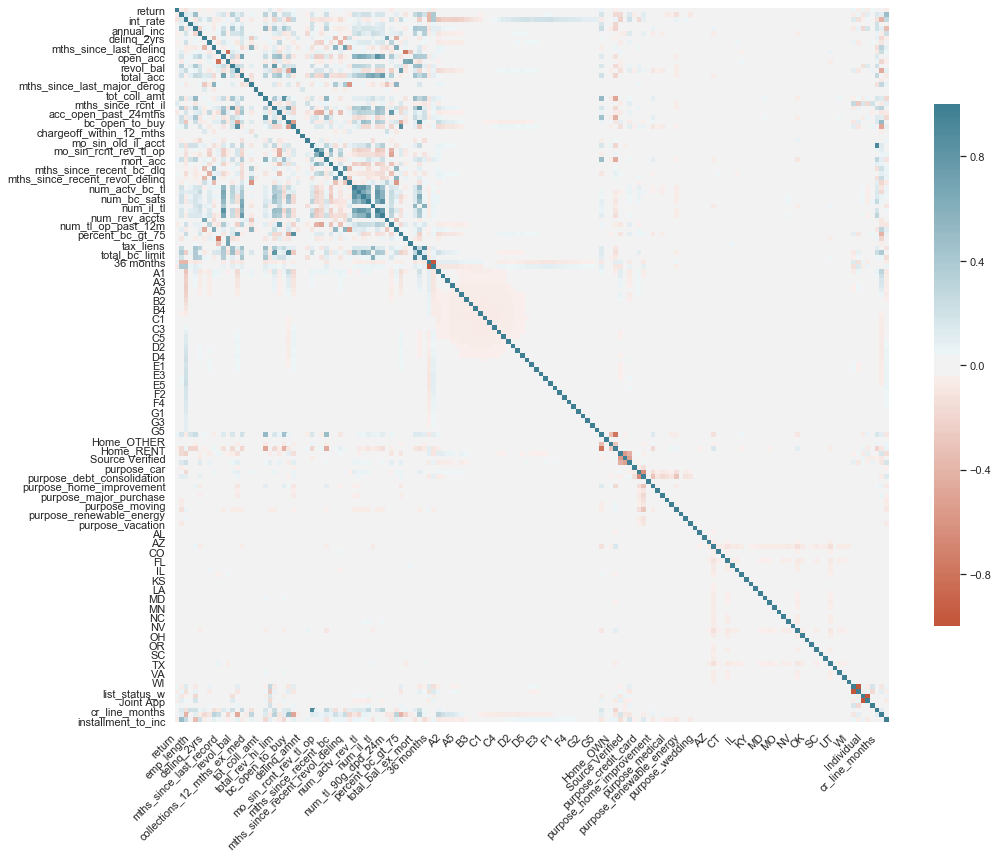

In [22]:
#Make a correlation heatmap

returns = lc_all['return']
lc_all.drop(labels=['return'], axis=1,inplace = True)
lc_all.insert(0, 'return', returns)

plt.figure(figsize=(16, 16))

corr = lc_all.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, cbar=True,cbar_kws={"shrink": .6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [24]:
#Random Forest Regression

target = ['return'] 
features = list(lc_all.drop(['return'],axis=1).columns)

#Scale features
lc_all[features] = scaler.fit_transform(lc_all[features])

#Create a Classifier
rfr=RandomForestRegressor(n_estimators=200, random_state = 42, 
                                max_depth = 10)

X = lc_all[features]
y = lc_all[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

rfr.fit(X_train, y_train)

print("Training Score:",rfr.score(X_train, y_train))

print("Test Score:",rfr.score(X_test, y_test))

y_true_rfr = y_test['return']
y_pred_rfr = rfr.predict(X_test)

print("RMSE:",round(sqrt(mean_squared_error(y_true_rfr, y_pred_rfr)), 2))

(1193198, 152)
(511371, 152)


C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training Score: 0.08037952448106078
Test Score: 0.05918917166161475
RMSE: 10.76


No handles with labels found to put in legend.


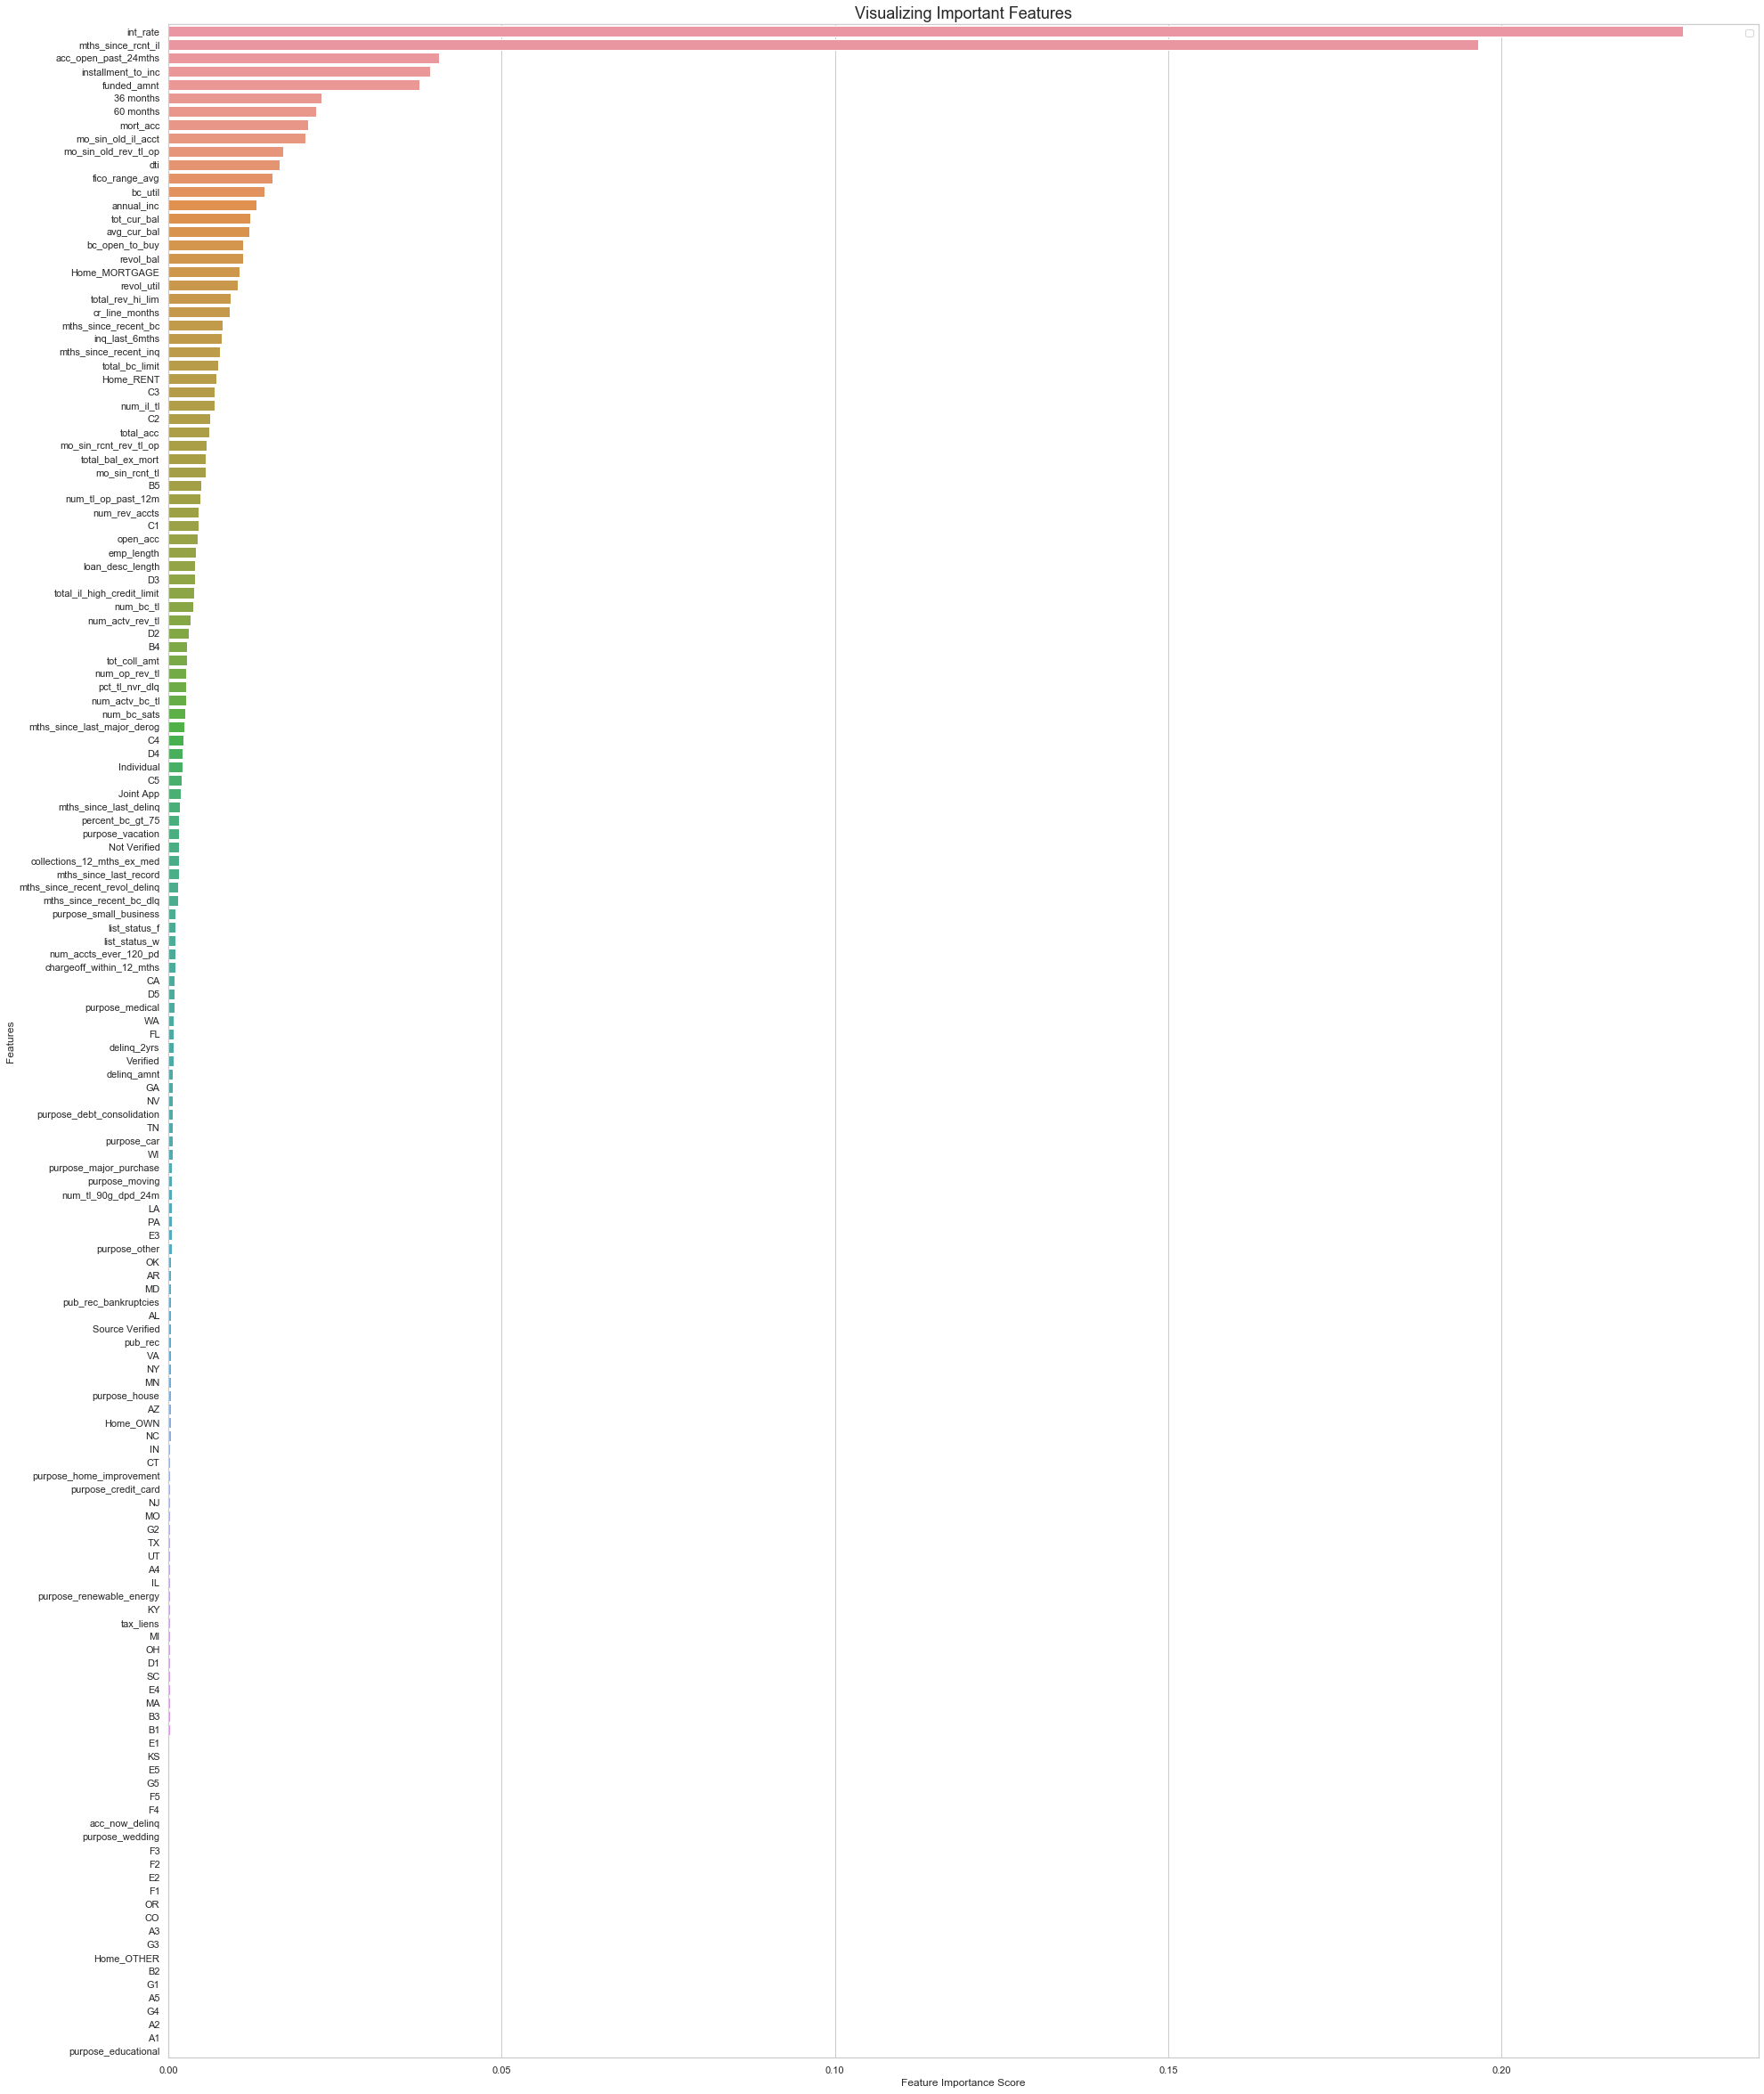

In [25]:
feature_imp = pd.Series(rfr.feature_importances_,index=features).sort_values(ascending=False)
plt.figure(figsize=(32, 42))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", fontsize=18)
plt.legend()
plt.show()

In [26]:
#Try XGBOOST

X = lc_all[features]
y = lc_all[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', max_depth = 3, n_estimators = 200)

xg_reg.fit(X_train,y_train)

y_pred_xg = xg_reg.predict(X_test)


(1193198, 152)
(511371, 152)


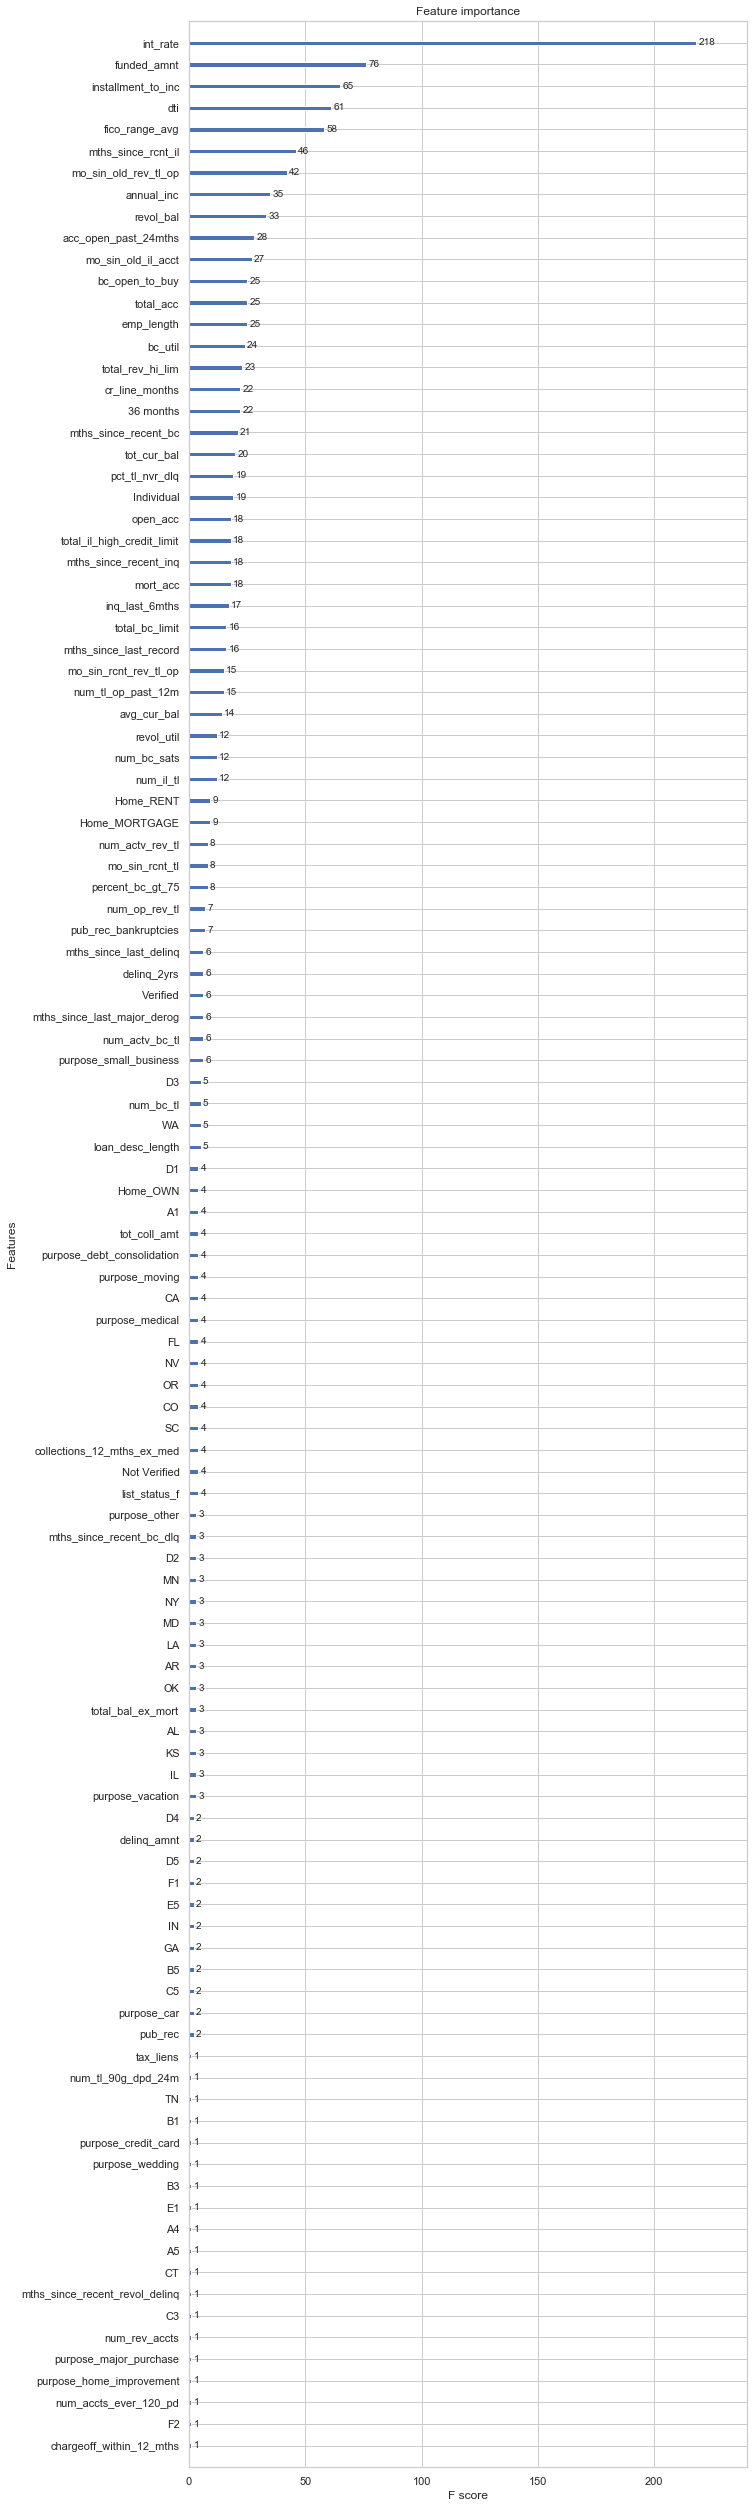

In [41]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10,45]
plt.show()

In [28]:
print("XGBoost R^2:",xg_reg.score(X_test, y_test))
print("XGBoost RMSE:",round(np.sqrt(mean_squared_error(y_test, y_pred_xg)), 2))

XGBoost R^2: 0.07221764590880875
XGBoost RMSE: 10.69


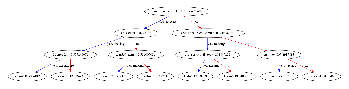

In [29]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [40, 10]
plt.show()

In [30]:
#Linear Regression


#RFE Feature Selection
#Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model 
#and choose either the best or worst performing feature, setting the feature aside and then
#repeating the process with the rest of the features.

sub_grade_remove = list(lc_all.loc[:,'A2':'G4'].columns)
target = ['return'] 
features_lr = list(lc_all.drop(['return',' 60 months','Home_OTHER',
                                              'Source Verified','purpose_other','GA',
                                              'list_status_w','Joint App']+sub_grade_remove,axis=1).columns)

X = lc_all[features_lr]
y = lc_all[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape); print(X_test.shape)

lr = LinearRegression(fit_intercept=True)
rfe = RFE(lr, 20)
rfe = rfe.fit(X_train, y_train)

print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), features_lr)))


(1193198, 112)
(511371, 112)


C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features sorted by their rank:
[(1, ' 36 months'), (1, 'Home_MORTGAGE'), (1, 'Home_OWN'), (1, 'Home_RENT'), (1, 'Individual'), (1, 'acc_open_past_24mths'), (1, 'annual_inc'), (1, 'bc_util'), (1, 'cr_line_months'), (1, 'dti'), (1, 'inq_last_6mths'), (1, 'installment_to_inc'), (1, 'int_rate'), (1, 'list_status_f'), (1, 'mo_sin_old_il_acct'), (1, 'mo_sin_old_rev_tl_op'), (1, 'mort_acc'), (1, 'mths_since_rcnt_il'), (1, 'open_acc'), (1, 'total_il_high_credit_limit'), (2, 'emp_length'), (3, 'num_bc_sats'), (4, 'total_bc_limit'), (5, 'bc_open_to_buy'), (6, 'pct_tl_nvr_dlq'), (7, 'num_op_rev_tl'), (8, 'revol_util'), (9, 'fico_range_avg'), (10, 'loan_desc_length'), (11, 'mths_since_last_record'), (12, 'pub_rec_bankruptcies'), (13, 'purpose_debt_consolidation'), (14, 'purpose_credit_card'), (15, 'WA'), (16, 'A1'), (17, 'mths_since_recent_inq'), (18, 'total_bal_ex_mort'), (19, 'delinq_2yrs'), (20, 'total_rev_hi_lim'), (21, 'revol_bal'), (22, 'num_bc_tl'), (23, 'SC'), (24, 'percent_bc_gt_75'), (25

In [31]:
#Top 30 features selected from RFE

features_sorted_by_rank = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), features_lr))
selected_features = [x[1] for x in features_sorted_by_rank[:30]]
selected_features

[' 36 months',
 'Home_MORTGAGE',
 'Home_OWN',
 'Home_RENT',
 'Individual',
 'acc_open_past_24mths',
 'annual_inc',
 'bc_util',
 'cr_line_months',
 'dti',
 'inq_last_6mths',
 'installment_to_inc',
 'int_rate',
 'list_status_f',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mort_acc',
 'mths_since_rcnt_il',
 'open_acc',
 'total_il_high_credit_limit',
 'emp_length',
 'num_bc_sats',
 'total_bc_limit',
 'bc_open_to_buy',
 'pct_tl_nvr_dlq',
 'num_op_rev_tl',
 'revol_util',
 'fico_range_avg',
 'loan_desc_length',
 'mths_since_last_record']

In [39]:
features_lr2 = [x for x in selected_features if x not in ['CA','Home_MORTGAGE','Home_OWN','Home_RENT']]

X = lc_all[features_lr2]
y = lc_all[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


#Use p-value to find the significance of variables
ols_model=sm.OLS(y_train,X_train)

result=ols_model.fit()

In [38]:
print(result.summary2())

                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.044       
Dependent Variable:     return           AIC:                         9075128.7721
Date:                   2020-05-08 15:21 BIC:                         9075452.5601
No. Observations:       1193198          Log-Likelihood:              -4.5375e+06 
Df Model:               27               F-statistic:                 2013.       
Df Residuals:           1193171          Prob (F-statistic):          0.00        
R-squared (uncentered): 0.044            Scale:                       117.66      
-----------------------------------------------------------------------------------
                               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-----------------------------------------------------------------------------------
 36 months                     0.6293    0.0116   54.0902  0.0000   0.6065   0.6521
Individual                

In [33]:
lr = LinearRegression(fit_intercept=True)

lr.fit(X_train, y_train)

lr_test_score=lr.score(X_test,y_test)

#Return the R^2
print("LR test score:",lr_test_score)

y_pred_lr = lr.predict(X_test)

print("RMSE =", sqrt(mean_squared_error(y_test, y_pred_lr)))

LR test score: 0.04408182178126274
RMSE = 10.850339446983723


In [42]:
random_portfolio_ret = []

for i in range(10000):
    random_ret = y_test.sample(1000).mean()
    random_portfolio_ret.append(random_ret)

print("Random Portfolio Returns = ",sum(random_portfolio_ret) / len(random_portfolio_ret))

Random Portfolio Expected Returns =  return   -0.006218
dtype: float64


In [62]:
y_test.shape

(511371, 1)

In [35]:
ml_ret = y_test.copy(deep=True)
ml_ret['pred_ret'] = y_pred_xg
ml_highest_1000 = ml_ret.sort_values('pred_ret',ascending=False)[0:1000]
print("XGBoost Portfolio Returns = ", ml_highest_1000['return'].mean())

XGBoost Portfolio Expected Returns =  5.652112546369349
